In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
errors = pd.read_csv("PdM_errors.csv")
failures = pd.read_csv("PdM_failures.csv")
machines = pd.read_csv("PdM_machines.csv")
maintenance = pd.read_csv("PdM_maint.csv")
telemetry = pd.read_csv("PdM_telemetry.csv")

In [3]:
errors

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


In [4]:
failures

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


In [5]:
maintenance

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4
...,...,...,...
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2


In [6]:
new_failures = failures.drop(columns=['datetime'], axis=1, inplace=False)
rating_data = new_failures.groupby('machineID')['failure'].value_counts().unstack()
rating_data

failure,comp1,comp2,comp3,comp4
machineID,,,,
1,1.0,2.0,NaN,4.0
2,1.0,3.0,NaN,NaN
3,1.0,4.0,NaN,NaN
4,2.0,4.0,NaN,NaN
5,4.0,3.0,NaN,NaN
...,...,...,...,...
96,NaN,NaN,5.0,NaN
97,NaN,1.0,3.0,4.0
98,4.0,4.0,5.0,3.0


In [7]:
errors["count"] = 1

error_features = errors.pivot_table(
    index="machineID",
    columns="errorID",
    values="count",
    aggfunc="sum",
    fill_value=0
).reset_index()

telemetry_agg = telemetry.groupby("machineID").agg({
    "volt": "mean",
    "rotate": "mean",
    "pressure": "mean",
    "vibration": "mean"
}).reset_index()

machine_features = machines.copy()

machine_features = (
    machine_features
    .merge(error_features, on="machineID", how="left")
    .merge(telemetry_agg, on="machineID", how="left")
)
machine_features.set_index('machineID', inplace=True)
machine_features

,model,age,error1,error2,error3,error4,error5,volt,rotate,pressure,vibration
machineID,,,,,,,,,,,
1,model3,18,11,6,9,5,4,170.833898,446.336502,100.668306,40.586309
2,model4,7,5,10,5,5,3,170.760482,446.388915,100.539930,40.301539
3,model3,8,11,10,8,8,2,170.659235,446.583238,100.653114,40.475376
4,model3,7,10,11,8,2,0,170.659728,446.053801,100.569902,40.341620
5,model3,2,14,8,7,6,3,171.044435,446.858577,101.066188,40.264846
...,...,...,...,...,...,...,...,...,...,...,...
96,model2,10,5,10,8,12,4,170.614552,448.311054,101.463938,40.248600
97,model2,14,12,8,5,15,5,170.343383,447.032374,101.043793,40.552751
98,model2,20,9,12,8,11,5,170.782478,446.066974,101.705498,40.499608


In [8]:
machine_features = pd.get_dummies(machine_features, 
                                 columns=["model"], 
                                 drop_first=False)
machine_features

,age,error1,error2,error3,error4,error5,volt,rotate,pressure,vibration,model_model1,model_model2,model_model3,model_model4
machineID,,,,,,,,,,,,,,
1,18,11,6,9,5,4,170.833898,446.336502,100.668306,40.586309,0,0,1,0
2,7,5,10,5,5,3,170.760482,446.388915,100.539930,40.301539,0,0,0,1
3,8,11,10,8,8,2,170.659235,446.583238,100.653114,40.475376,0,0,1,0
4,7,10,11,8,2,0,170.659728,446.053801,100.569902,40.341620,0,0,1,0
5,2,14,8,7,6,3,171.044435,446.858577,101.066188,40.264846,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,10,5,10,8,12,4,170.614552,448.311054,101.463938,40.248600,0,1,0,0
97,14,12,8,5,15,5,170.343383,447.032374,101.043793,40.552751,0,1,0,0
98,20,9,12,8,11,5,170.782478,446.066974,101.705498,40.499608,0,1,0,0


In [9]:
maintenance["total_maint_count"] = 1
maint_counts = maintenance.groupby(["machineID", "comp"])["total_maint_count"].sum().reset_index()

maintenance['datetime'] = pd.to_datetime(maintenance['datetime'])
CURRENT_DATE = maintenance['datetime'].max()
recency_dates = maintenance.groupby(['machineID', 'comp'])['datetime'].max().reset_index(name='last_maintenance_date')
recency_dates['how_recent'] = (CURRENT_DATE - recency_dates['last_maintenance_date']).dt.days
recency_dates

component_features = (
    maint_counts
    .merge(recency_dates, on=["machineID", "comp"], how="inner")
)
component_features.set_index('machineID', inplace=True)
component_features


,comp,total_maint_count,last_maintenance_date,how_recent
machineID,,,,
1,comp1,11,2015-12-31 06:00:00,1
1,comp2,9,2015-11-16 06:00:00,46
1,comp3,8,2015-12-01 06:00:00,31
1,comp4,9,2015-12-16 06:00:00,16
2,comp1,7,2015-12-14 06:00:00,18
...,...,...,...,...
99,comp4,7,2015-12-14 06:00:00,18
100,comp1,10,2015-10-10 06:00:00,83
100,comp2,4,2015-12-24 06:00:00,8


In [10]:
def calculate_component_bias(component_features, rating_data=rating_data, alpha=0.3):
    component_features = component_features.copy()

    maint_count_wide = component_features.pivot_table(
        index='machineID', columns='comp', values='total_maint_count', aggfunc='max'
    ).fillna(0)

    recency_wide = component_features.pivot_table(
        index='machineID', columns='comp', values='how_recent', aggfunc='max'
    ).fillna(0)

    scaler_count = MinMaxScaler()
    count_risk = pd.DataFrame(scaler_count.fit_transform(maint_count_wide),
                              index=maint_count_wide.index,
                              columns=maint_count_wide.columns)

    scaler_recency = MinMaxScaler()
    recency_risk = pd.DataFrame(1 - scaler_recency.fit_transform(recency_wide),
                                index=recency_wide.index,
                                columns=recency_wide.columns)

    final_bias = (alpha * count_risk + ((1 - alpha) * recency_risk))  
    return rating_data * (1 + final_bias)

In [11]:
def find_topk_similar_machines(target_user,rating_data, machine_features_df, similarity_metric, k, feature_weight):
        data_copy = rating_data.copy()
        user_means = data_copy.mean(axis=1)
        data_centered = data_copy.sub(user_means, axis=0)
        data_filled = data_centered.fillna(0) # For similarity calculation

        scaler = StandardScaler()
        scaled_features = pd.DataFrame(scaler.fit_transform(machine_features_df), 
                                    index=machine_features_df.index, 
                                    columns=machine_features_df.columns)

        target_ratings = rating_data.loc[target_user]
        if not target_ratings.isna().any():
            print(f"Note: Every component in Machine {target_user} has failed at least once before. Instead of using a CF approach we will just return the components from most fails to least fails in this machine. \n")
            s = pd.Series(target_ratings)
            return (s.sort_values(ascending=False), "flag")
        
        # similarity calculations only based on failure counts
        history_similarity_scores = {}
        target_vector_1d = data_filled.loc[target_user].values
        target_vector_2d = target_vector_1d.reshape(1, -1)

        # similarity between machines based on features
        feature_similarity_scores = {}
        target_feature_vector_1d = scaled_features.loc[target_user].values
        target_feature_vector_2d = target_feature_vector_1d.reshape(1, -1) 

        if similarity_metric == "L2":
            for user in data_filled.index:
                if user == target_user: continue
                user_vector = data_filled.loc[user].values
                # L2 is distance, so we use negative distance for similarity
                history_similarity_scores[user] = -np.linalg.norm(target_vector_1d - user_vector)

            for user in data_filled.index:
                if user == target_user: continue
                user_feature_vector = scaled_features.loc[user].values
                # L2 is distance, so we use negative distance for similarity
                feature_similarity_scores[user] = -np.linalg.norm(target_feature_vector_1d - user_feature_vector)

        elif similarity_metric == "Cosine":
            all_similarities = cosine_similarity(data_filled.values, target_vector_2d)
            for i, user in enumerate(data_filled.index):
                if user != target_user:
                    history_similarity_scores[user] = all_similarities[i, 0]

            all_feature_similarities = cosine_similarity(scaled_features.values, target_feature_vector_2d)
            for i, user in enumerate(scaled_features.index):
                if user != target_user:
                    feature_similarity_scores[user] = all_feature_similarities[i, 0]

        else:
            print("Error: Unsupported similarity metric. Use 'L2' or 'Cosine'.")
            return None

        # combine similarity scores
        similar_history = pd.Series(history_similarity_scores)
        similar_machines = pd.Series(feature_similarity_scores)
        new_scaler = MinMaxScaler()
        similar_history_scaled = pd.Series(new_scaler.fit_transform(similar_history.values.reshape(-1, 1)).flatten(), index=similar_history.index)
        similar_machines_scaled = pd.Series(new_scaler.fit_transform(similar_machines.values.reshape(-1, 1)).flatten(), index=similar_machines.index)
        combined_similarity = (1 - feature_weight) * similar_history_scaled + feature_weight * similar_machines_scaled # weighted average

        # get top k similar users
        top_k_users = combined_similarity.nlargest(k)
        return top_k_users
        

In [12]:
# k must be between 1 and 4 (inclusive) as there are only 4 components 
# target_user needs to be inputed as the machineID number -> between 1 and 100 (inclusive)
def feature_aware_user_CF(target_user, k=4, similarity_metric = 'Cosine', feature_weight=0.4, rating_data = rating_data, 
                          machine_features_df = machine_features, component_features_df = component_features):
        if target_user not in rating_data.index:
            print(f"Error: Machine {target_user} not found.")
            return None
        
        adjusted_rating_data = calculate_component_bias(component_features_df, rating_data)
        
        top_k_users = find_topk_similar_machines(target_user, adjusted_rating_data, machine_features_df, similarity_metric, k, feature_weight)

        # for machines that have no unrated components
        if isinstance(top_k_users, tuple):
             return top_k_users[0]

        target_ratings = adjusted_rating_data.loc[target_user]
        target_unrated = target_ratings[target_ratings.isna()].index

        OGdata_featured = adjusted_rating_data.copy()
        similar_users_df = OGdata_featured.loc[top_k_users.keys(), target_unrated]
        user_means = OGdata_featured.loc[top_k_users.keys()].mean(axis=1)
        similar_users_df = similar_users_df.apply(lambda col: col.fillna(user_means))

        # using newly scored ratings to get the weighted avg
        weights = pd.Series(top_k_users)
        weighted_avg = ((similar_users_df.T * weights).T.sum(axis=0))/ weights.sum()
        # just in case there are any NaNs left (if all similar users had NaN for a component)
        weighted_avg = weighted_avg.fillna(OGdata_featured[target_unrated].mean())

        # including already known ratings so we can have a complete picture of the rankings
        final_scores = pd.concat([target_ratings, weighted_avg])
    
        ranked = final_scores.sort_values(ascending=False)

        return ranked.dropna()

In [13]:
rating_data.loc[42]

failure
comp1    2.0
comp2    3.0
comp3    4.0
comp4    NaN
Name: 42, dtype: float64

In [14]:
rating_data_test = calculate_component_bias(component_features, rating_data)
rating_data_test.loc[42]

failure
comp1    3.526316
comp2    5.231138
comp3    6.970492
comp4         NaN
Name: 42, dtype: float64

In [15]:
feature_aware_user_CF(target_user=42)

failure
comp3    6.970492
comp4    5.243644
comp2    5.231138
comp1    3.526316
dtype: float64

This is cool because now we can see a more complete picture! We might have correctly assumed that comp2 was mostly likely to fail next from the original ratings (assuming the next component to fail already fails the most) but we would not have been able to make accurate predictions about the un-rated components so we might have assumed the next likely component is comp1. With this method we can assume that comp3 is the next to fail based on the machines that similar to it. Obviously we do have to take this reccomendation with a grain of salt since the components we imputed ratings for never failed at the time of making the table so maybe the high risk we predicted is an artifact of their neighbors' history rather than their own weakness. 

### Evaluation & Graphs!

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [17]:
has_missing_ratings = rating_data.isna().any(axis=1)
fully_rated_mask = ~has_missing_ratings
test_machines = rating_data[fully_rated_mask].index.tolist()
test_machines

[13, 17, 20, 21, 22, 23, 35, 37, 71, 73, 85, 95, 98, 99]

In [18]:
k_values = [2, 3, 4, 5]
similarity_metrics = ["Cosine", "L2"]
feature_weights = [0.3, 0.4, 0.5, 0.6]

all_results = []

In [19]:
rating_data.loc[99]

failure
comp1    2.0
comp2    6.0
comp3    6.0
comp4    5.0
Name: 99, dtype: float64

In [20]:
import random
random.seed(10)

test_dataset = rating_data.copy(deep=True)

for machineID in test_machines:
    ratings = test_dataset.loc[machineID]
    comp_to_mask = random.choice(ratings.index.tolist())
    test_dataset.at[machineID, comp_to_mask] = np.nan

test_dataset.loc[99]

failure
comp1    2.0
comp2    NaN
comp3    6.0
comp4    5.0
Name: 99, dtype: float64

In [21]:
test_dataset_test = calculate_component_bias(component_features, test_dataset)
test_dataset_test.loc[99]

failure
comp1     2.949282
comp2          NaN
comp3    10.192623
comp4     8.761801
Name: 99, dtype: float64

In [22]:
for similarity_metric in similarity_metrics:
    for k in k_values:
        for feature_weight in feature_weights:
            print(f"Testing: {similarity_metric}, k={k}, fw={feature_weight}")
            
            # store metrics for this configuration
            rmse_scores = []
            mae_scores = []
            accuracy_scores = []
            n_valid_tests = 0
            
            for test_machine in test_machines:
                if test_machine == 100:
                    pass
                predicted_rankings = feature_aware_user_CF(
                    target_user=test_machine,
                    k=k,
                    similarity_metric=similarity_metric,
                    feature_weight=feature_weight,
                    rating_data=test_dataset_test,
                    machine_features_df=machine_features,
                    component_features_df=component_features
                )
                
                #actual_ratings = test_dataset.loc[test_machine].dropna()
                actual_ratings = test_dataset.loc[test_machine].fillna(0)
                
                # align predicted and actual ratings
                common_components = actual_ratings.index.intersection(predicted_rankings.index)
                
                if len(common_components) == 0:
                    continue
                
                predicted_values = predicted_rankings.loc[common_components]
                actual_values = actual_ratings.loc[common_components]
                
                rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
                mae = mean_absolute_error(actual_values, predicted_values)
                
                # accuracy: proportion of correctly predicted top 2 failed components, not entirely sure if this is the best way to do it for this context
                top_2_predicted = set(predicted_rankings.head(2).index)
                top_2_actual = set(actual_ratings.sort_values(ascending=False).head(2).index)
                accuracy = len(top_2_predicted.intersection(top_2_actual)) / 2
                
                rmse_scores.append(rmse)
                mae_scores.append(mae)
                accuracy_scores.append(accuracy)
                n_valid_tests += 1

                if n_valid_tests > 0:
                    avg_rmse = np.mean(rmse_scores)
                    avg_mae = np.mean(mae_scores)
                    avg_accuracy = np.mean(accuracy_scores)
                    
                    all_results.append({
                        'similarity_metric': similarity_metric,
                        'k': k,
                        'feature_weight': feature_weight,
                        'rmse': avg_rmse,
                        'mae': avg_mae,
                        'accuracy': avg_accuracy,
                        'n_tests': n_valid_tests
                    })

results_df = pd.DataFrame(all_results)
results_df

Testing: Cosine, k=2, fw=0.3
Testing: Cosine, k=2, fw=0.4
Testing: Cosine, k=2, fw=0.5
Testing: Cosine, k=2, fw=0.6
Testing: Cosine, k=3, fw=0.3
Testing: Cosine, k=3, fw=0.4
Testing: Cosine, k=3, fw=0.5
Testing: Cosine, k=3, fw=0.6
Testing: Cosine, k=4, fw=0.3
Testing: Cosine, k=4, fw=0.4
Testing: Cosine, k=4, fw=0.5
Testing: Cosine, k=4, fw=0.6
Testing: Cosine, k=5, fw=0.3
Testing: Cosine, k=5, fw=0.4
Testing: Cosine, k=5, fw=0.5
Testing: Cosine, k=5, fw=0.6
Testing: L2, k=2, fw=0.3
Testing: L2, k=2, fw=0.4
Testing: L2, k=2, fw=0.5
Testing: L2, k=2, fw=0.6
Testing: L2, k=3, fw=0.3
Testing: L2, k=3, fw=0.4
Testing: L2, k=3, fw=0.5
Testing: L2, k=3, fw=0.6
Testing: L2, k=4, fw=0.3
Testing: L2, k=4, fw=0.4
Testing: L2, k=4, fw=0.5
Testing: L2, k=4, fw=0.6
Testing: L2, k=5, fw=0.3
Testing: L2, k=5, fw=0.4
Testing: L2, k=5, fw=0.5
Testing: L2, k=5, fw=0.6


,similarity_metric,k,feature_weight,rmse,mae,accuracy,n_tests
0,Cosine,2,0.3,8.236615,7.999511,0.500000,1
1,Cosine,2,0.3,8.550732,8.323728,0.500000,2
2,Cosine,2,0.3,7.935675,7.732383,0.666667,3
3,Cosine,2,0.3,7.844591,7.666847,0.750000,4
4,Cosine,2,0.3,7.823213,7.625242,0.800000,5
...,...,...,...,...,...,...,...
443,L2,5,0.6,7.283971,6.796809,0.750000,10
444,L2,5,0.6,7.277308,6.768776,0.727273,11
445,L2,5,0.6,7.180632,6.677292,0.708333,12
446,L2,5,0.6,7.293723,6.819530,0.730769,13


In [23]:
results_sorted = results_df.sort_values('rmse').reset_index(drop=True)
results_sorted

,similarity_metric,k,feature_weight,rmse,mae,accuracy,n_tests
0,L2,3,0.4,6.821599,6.539510,0.785714,7
1,L2,4,0.3,6.836477,6.558613,0.857143,7
2,L2,2,0.4,6.853011,6.553306,0.714286,7
3,L2,2,0.6,6.853930,6.792590,1.000000,1
4,L2,3,0.3,6.859907,6.572538,0.857143,7
...,...,...,...,...,...,...,...
443,L2,2,0.3,8.333044,8.143716,0.750000,2
444,Cosine,2,0.6,8.413983,8.218863,0.500000,2
445,Cosine,4,0.6,8.473460,8.236434,0.750000,2
446,Cosine,2,0.3,8.550732,8.323728,0.500000,2


In [24]:
best_config = results_df.sort_values(['accuracy', 'rmse'], ascending=[False, True]).iloc[0]
best_config

similarity_metric         L2
k                          2
feature_weight           0.6
rmse                 6.85393
mae                  6.79259
accuracy                 1.0
n_tests                    1
Name: 266, dtype: object

Text(0.5, 1.0, 'Accuracy by K and Similarity Metric')

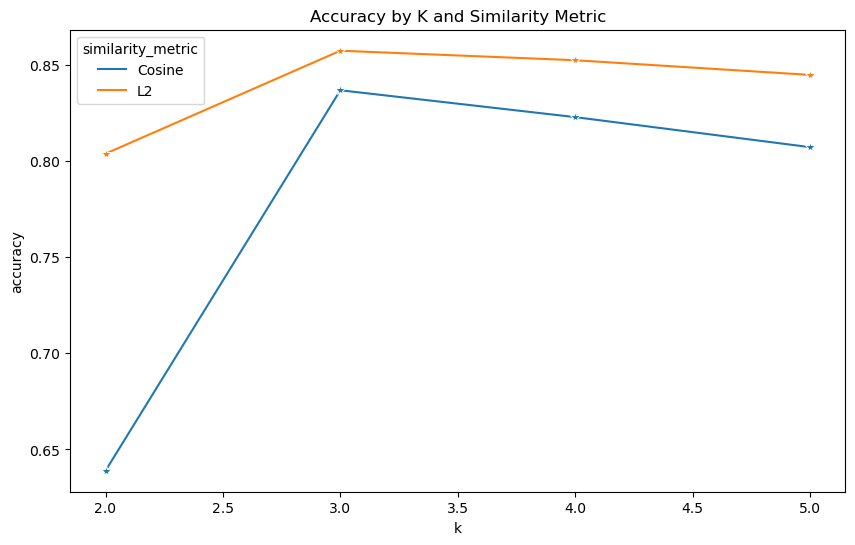

In [25]:
k_and_similarity1 = results_df.groupby(['k', 'similarity_metric'], as_index=False)['accuracy'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=k_and_similarity1,
    x='k',
    y='accuracy',
    hue='similarity_metric',
    marker='*',
    markersize=8
)
plt.title('Accuracy by K and Similarity Metric')

Text(0.5, 1.0, 'RMSE by K and Similarity Metric')

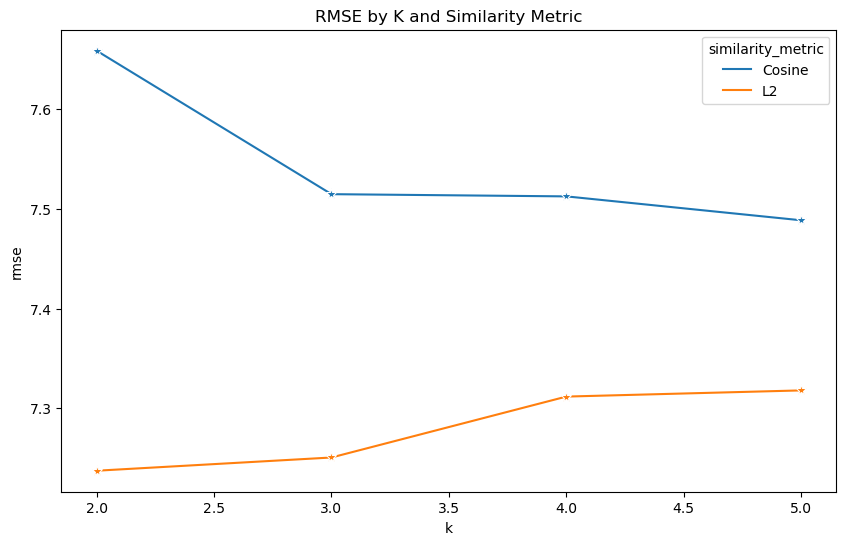

In [26]:
k_and_similarity2 = results_df.groupby(['k', 'similarity_metric'], as_index=False)['rmse'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=k_and_similarity2,
    x='k',
    y='rmse',
    hue='similarity_metric',
    marker='*',
    markersize=8
)
plt.title('RMSE by K and Similarity Metric')

Text(0.5, 1.0, 'MAE by K and Similarity Metric')

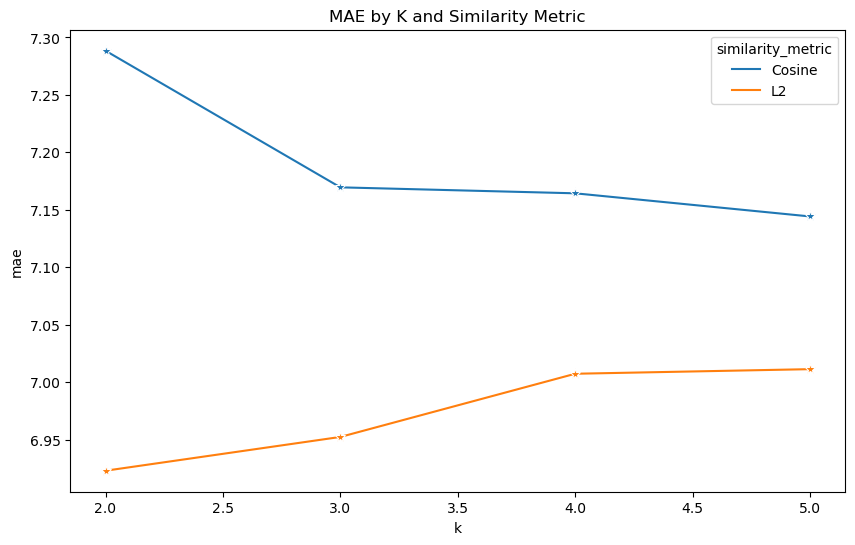

In [27]:
k_and_similarity3 = results_df.groupby(['k', 'similarity_metric'], as_index=False)['mae'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=k_and_similarity3,
    x='k',
    y='mae',
    hue='similarity_metric',
    marker='*',
    markersize=8
)
plt.title('MAE by K and Similarity Metric')

In [28]:
actual_ratings_best = test_dataset.loc[35].fillna(0)
predicted_rankings_best = feature_aware_user_CF(
                    target_user=35,
                    k=2,
                    similarity_metric='L2',
                    feature_weight=0.6,
                    rating_data=test_dataset_test,
                    machine_features_df=machine_features,
                    component_features_df=component_features
                )

comparison_df = pd.DataFrame({
    'actual': actual_ratings_best,
    'predicted': predicted_rankings_best
})
comparison_df

,actual,predicted
failure,,
comp1,4.0,8.817206
comp2,1.0,3.174876
comp3,2.0,2.470755
comp4,0.0,10.364591


9.535450437181377e-06


Text(0.5, 1.0, 'Actual vs. Predicted Risk Scores for Best Config (for Machine 35)')

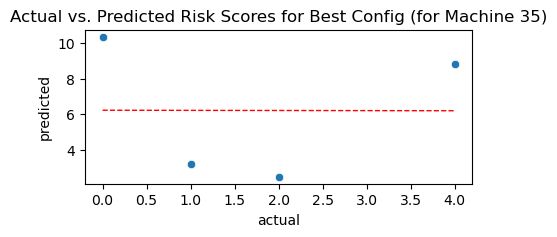

In [33]:
plt.figure(figsize=(5, 2))
sns.scatterplot(
        data=comparison_df,
        x='actual',
        y='predicted'
)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    comparison_df['actual'], 
    comparison_df['predicted']
)

r_squared = r_value ** 2
print(r_squared)

x_line = np.array([comparison_df['actual'].min(), comparison_df['actual'].max()])
y_line = intercept + slope * x_line

plt.plot(x_line, y_line, color='red', linestyle='--', linewidth=1, label=f'Fit line: y={slope:.2f}x+{intercept:.2f}')


plt.title(f'Actual vs. Predicted Risk Scores for Best Config (for Machine 35)')